In [101]:
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Activation
import datetime
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

korean_air_01 = pd.read_csv("korean_air_score/korean_air_1_score.csv")
korean_air_02 = pd.read_csv("korean_air_score/korean_air_2_score.csv")
korean_air_03 = pd.read_csv("korean_air_score/korean_air_3_score.csv")
korean_air_04 = pd.read_csv("korean_air_score/korean_air_4_score.csv")
korean_air_05 = pd.read_csv("korean_air_score/korean_air_5_score.csv")
korean_air_06 = pd.read_csv("korean_air_score/korean_air_6_score.csv")
korean_air_07 = pd.read_csv("korean_air_score/korean_air_7_score.csv")
korean_air_08 = pd.read_csv("korean_air_score/korean_air_8_score.csv")
korean_air_09 = pd.read_csv("korean_air_score/korean_air_9_score.csv")
korean_air_10 = pd.read_csv("korean_air_score/korean_air_10_score.csv")
korean_air_1112 = pd.read_csv("korean_air_score/korean_air_11~12_score.csv")

score_data = pd.concat([korean_air_01,korean_air_02,korean_air_03,korean_air_04,korean_air_05,\
                       korean_air_06,korean_air_07,korean_air_08,korean_air_09,korean_air_10,\
                       korean_air_1112],ignore_index=True)

score_data

,date,score
0,2020/01/01,-0.486075
1,2020/01/05,-0.484725
2,2020/01/06,-0.488301
3,2020/01/07,-0.484205
4,2020/01/08,-0.476674
...,...,...
323,2020/12/08,-0.446635
324,2020/12/09,-0.429806
325,2020/12/10,-0.439037
326,2020/12/11,-0.358899


In [102]:
weight_score = []

for x in range(0,len(score_data)):
    
    try : 
        
        weight = score_data.score[x]
        weight += score_data.score[x - 1] * 0.5
        weight += score_data.score[x - 2] * 0.25
        weight += score_data.score[x - 3] * 0.15
        weight += score_data.score[x - 4] * 0.05
        weight += score_data.score[x - 5] * 0.05
        
        weight_score.append(weight)
        
    except KeyError :
        
        weight_score.append(weight)
        

In [129]:
#가중치를 주지 않았을때
data = score_data
#가중치를 주었을 때
#data = pd.DataFrame(weight_score)

In [130]:
# 결측치 제거
dataset = data.dropna()

In [131]:
dataset.columns = ["score"]

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [132]:
mid_prices = dataset['score'].values

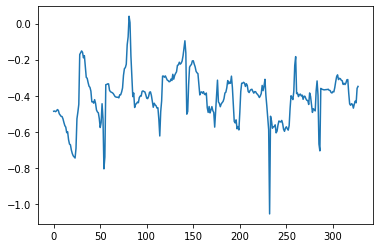

In [150]:
plt.plot(mid_prices)

In [9]:
len(mid_prices)

28

In [133]:
seq_len = 20
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [142]:
# z-score 정규화
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window)) / np.std(window)) \
                         for p in window]
    normalized_data.append(normalized_window)
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

result = np.array(normalized_data)


row = int(round(result.shape[0] * 0.8))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((246, 20, 1), (61, 20, 1))

In [149]:
result

array([[ 0.71945122, -0.25015054, -1.24052428, ...,  0.41669076,
         0.53357714,  0.59119063],
       [ 1.44514727,  1.23044794,  1.15406463, ..., -1.54809881,
        -0.94043821,  0.91226302],
       [ 0.12261339, -0.08878047,  0.31309061, ...,  2.53587011,
        -0.65180668, -2.73778838],
       ...,
       [ 1.06660834,  1.22282708,  0.81129642, ..., -1.66694427,
        -1.32035166, -1.0567329 ],
       [ 1.32890779,  0.91796972,  1.02573888, ..., -1.2106088 ,
        -0.94736964, -1.0917589 ],
       [ 1.01828827,  1.1310098 ,  1.09826104, ..., -0.93276999,
        -1.08379444,  0.22728349]])

In [143]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(20, 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam'),

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 20, 50)            10400     
_________________________________________________________________
dropout_25 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 32)                10624     
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


In [144]:
weight_path = "./weights.hdf5"

model.fit(x_train, y_train,validation_data=(x_test, y_test),batch_size=16,epochs=200,\
          callbacks=[ModelCheckpoint(filepath = weight_path,monitor='val_loss', verbose=1,save_best_only=True),\
                     EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

Train on 246 samples, validate on 61 samples
Epoch 1/200
246/246 [==============================] - 1s 4ms/step - loss: 1.6461 - val_loss: 1.0758

Epoch 00001: val_loss improved from inf to 1.07583, saving model to ./weights.hdf5
Epoch 2/200
246/246 [==============================] - 0s 894us/step - loss: 1.0387 - val_loss: 0.7772

Epoch 00002: val_loss improved from 1.07583 to 0.77723, saving model to ./weights.hdf5
Epoch 3/200
246/246 [==============================] - 0s 926us/step - loss: 0.7618 - val_loss: 0.7217

Epoch 00003: val_loss improved from 0.77723 to 0.72171, saving model to ./weights.hdf5
Epoch 4/200
246/246 [==============================] - 0s 959us/step - loss: 0.7218 - val_loss: 0.6654

Epoch 00004: val_loss improved from 0.72171 to 0.66539, saving model to ./weights.hdf5
Epoch 5/200
246/246 [==============================] - 0s 995us/step - loss: 0.6157 - val_loss: 0.6193

Epoch 00005: val_loss improved from 0.66539 to 0.61927, saving model to ./weights.hdf5
Epoch 

In [145]:
pred = model.predict(x_test)

In [146]:
# 복원
pred_result = []
pred_y = []
for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    pred_result.append(n1)
    pred_y.append(n2)

In [147]:

mse = model.evaluate(x_test,y_test,batch_size=16)
print(mse)

def RMSE(y_test,pred_result):
    return np.sqrt(mean_squared_error(y_test,pred))
print(RMSE(y_test,pred_result))

pred_r2 = r2_score(y_test,pred)
print(pred_r2)

61/61 [==============================] - 0s 225us/step
0.27722937308373996
0.5265257621846908
0.8124037865046657


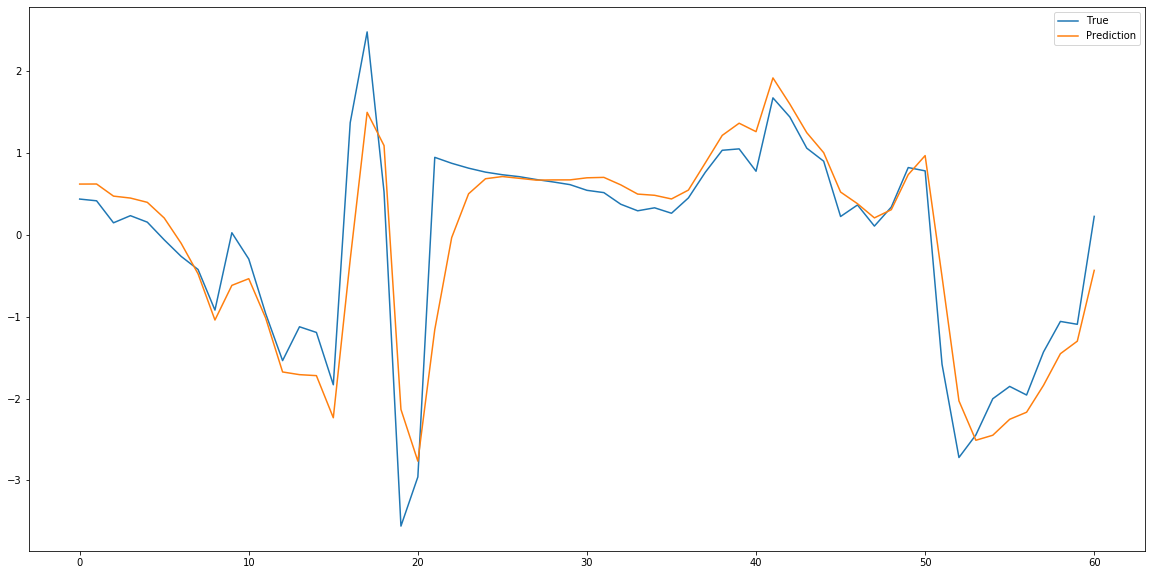

In [148]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(pred, label='True')
ax.plot(pred_result, label='Prediction')
ax.legend()
plt.show()